In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings # ignore warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [3]:
DATA_PATH = "./faces/"
CSV_PATH = "./faces/face_landmarks.csv"

landmarks_frame = pd.read_csv(CSV_PATH)
n = 65
img_name = landmarks_frame.iloc[n, 0] # iloc is to access the data by index
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks) # convert the landmarks to a numpy array
landmarks = landmarks.astype("float").reshape(-1, 2)

print("Image name: {}".format(img_name))
print("Landmarks shape: {}".format(landmarks.shape))
print("First 4 Landmarks: {}".format(landmarks[:4]))


Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [4]:
landmarks_frame

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,matt-mathes.jpg,85,152,83,173,83,195,85,217,91,...,160,224,190,225,162,236,151,237,141,235
65,person-7.jpg,32,65,33,76,34,86,34,97,37,...,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,...,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,...,85,130,94,130,85,128,81,128,77,128


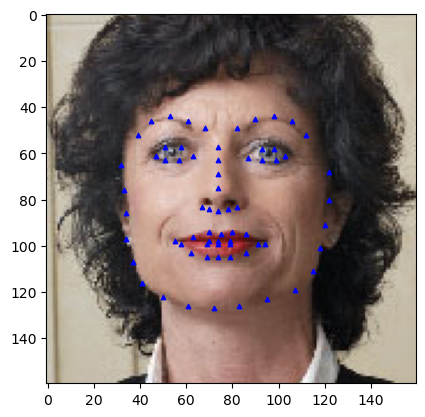

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker="^", c="b")
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join(DATA_PATH, img_name)), landmarks)
plt.show()

In [6]:
class FaceDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(CSV_PATH)
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): # if the index is a tensor, convert it to a list
            idx = idx.tolist()

        img_name = os.path.join(self.root, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)

        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.asarray(landmarks)
        landmarks = landmarks.astype("float").reshape(-1, 2)
        sample = {"image": image, "landmarks": landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample



0 (324, 215, 3) (68, 2)


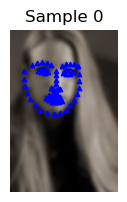

1 (500, 333, 3) (68, 2)


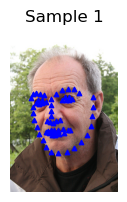

2 (250, 258, 3) (68, 2)


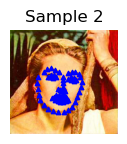

3 (434, 290, 3) (68, 2)


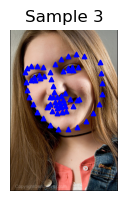

In [7]:
face_dataset = FaceDataset(csv_file=CSV_PATH, root_dir=DATA_PATH)

fig = plt.figure()
for i, sample in enumerate(face_dataset):
    print(i, sample["image"].shape, sample["landmarks"].shape)
    ax = plt.subplot(1, 4, i + 1)
     # plt.tight_layout() # automatically adjust subplot parameters to give specified padding
    ax.set_title("Sample {}".format(i))
    ax.axis("off")
    show_landmarks(**sample) # ** stands for unpacking the dictionary
    if i == 3:
        plt.show()
        break


In [9]:
class Rescale():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # this will raise an error if the output_size is not an int or tuple
        self.output_size = output_size

    def __call__(self, sample):
        img, landmarks = sample["image"], sample["landmarks"]
        h, w = img.shape[:2] # also h, w = img.shape[0], img.shape[1]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h

        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(img, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h] # this is to scale the landmarks as well

        return {"image": img, "landmarks": landmarks}

class RandomCrop():
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size) # if the output_size is an int, then we make it a tuple
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        img, landmarks = sample["image"], sample["landmarks"]
        h, w = img.shape[0], img.shape[1]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0,  w - new_w + 1)

        img = img[top: top + new_h, left: left + new_w]
        landmarks = landmarks - [left, top]

        return {"image": img, "landmarks": landmarks}

class ToTensor():
    def __call__(self, sample):
        img, landmarks = sample["image"], sample["landmarks"]
        img = img.transpose((2, 0, 1)) # [H, W, C] -> [C, H, W]
        return {"image": torch.from_numpy(img), "landmarks": torch.from_numpy(landmarks)}

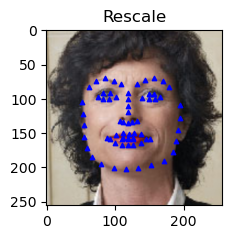

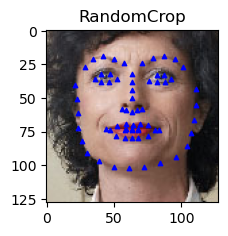

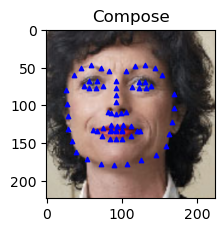

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])


fig = plt.figure()
sample = face_dataset[65]
for i, trans in enumerate([scale, crop, composed]):
    transformed = trans(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout() # automatically adjust subplot parameters to give specified padding
    ax.set_title(type(trans).__name__)
    show_landmarks(**transformed)

plt.show()

In [17]:
transformed_dataset = FaceDataset(csv_file = CSV_PATH,
                                  root_dir = DATA_PATH,
                                  transform = transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))

# create the Dataloader
dataloader = DataLoader(transformed_dataset, batch_size = 4, shuffle = True, num_workers = 0)

one_batch = next(iter(dataloader))
img, marks = one_batch["image"], one_batch["landmarks"]
img.shape

torch.Size([4, 3, 224, 224])

In [31]:
def show_batch_img(sample_batched):
    img_batch, landmark_batch = sample_batched["image"], sample_batched["landmarks"]
    batch_size = len(img_batch)

    plt.figure()
    plt.tight_layout()
    for i in range(batch_size):
        ax = plt.subplot(batch_size, 1, i + 1)
        img = img_batch[i].squeeze().permute(1, 2, 0).numpy()
        show_landmarks(img, landmark_batch[i])
    plt.show()


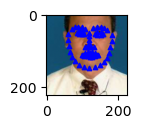

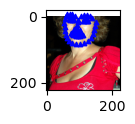

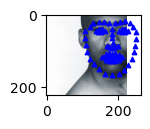

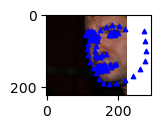

In [32]:
show_batch_img(one_batch)